# Lab 02 — Yaw-rate Mapping (Section 5, linear per-speed fits + rate coupling)

We map steering command \(\alpha\) (servo units, not radians) and speed command \(v\) (GUI units) to yaw-rate \(w\) (rad/s).

Global frame convention:
- \(x_G\): forward
- \(y_G\): right

We recorded final displacements after a fixed duration \(T\). The sheet stores:
- \(x+24.5\) in cm
- \(y+10\) in cm

So we recover:
\[
x_G = (x_{\text{meas}} - 24.5)\text{ cm},\qquad
y_G = (y_{\text{meas}} - 10)\text{ cm}
\]
and convert to meters.

**Sign fix:** for negative steering, the sheet kept the magnitude of \(y\). We restore the sign:
- if \(\alpha < 0\): \(y_G \leftarrow -|y_G|\)
- if \(\alpha > 0\): \(y_G \leftarrow +|y_G|\)

Yaw change and yaw-rate are estimated by:
\[
\Delta\theta \approx 2\,\mathrm{atan2}(y_G,x_G),\qquad
w = \frac{\Delta\theta}{T}.
\]

We then:
1. Fit per-speed linear models through origin:
\[
w \approx k_w(v)\,\alpha
\]
2. Use Phase 3 calibration \(r(v)\) (counts/s) and fit:
\[
k_w(v)\approx c_r\,r(v).
\]
This yields a compact model:
\[
w \approx (c_r\,r(v))\,\alpha.
\]


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
# Trial duration (seconds) for the yaw trials
T = 3.5

# Each row: (alpha, speed, x_plus_24p5_cm, y_plus_10_cm)
rows = []

# alpha=10, v=100
rows += [(10, 100, 95,   56),
         (10, 100, 96,   60),
         (10, 100, 95,   60),
         (10, 100, 96,   60),
         (10, 100, 97,   63),
         (10, 100, 100,  57)]

# alpha=10, v=80
rows += [(10, 80,  81,   39.5),
         (10, 80,  86,   42),
         (10, 80,  83,   43),
         (10, 80,  86,   45),
         (10, 80,  80,   43)]

# alpha=15, v=100
rows += [(15, 100, 80,   82),
         (15, 100, 80.5, 81),
         (15, 100, 78,   85.5),
         (15, 100, 75,   87.5),
         (15, 100, 76,   80)]

# alpha=-10, v=100  (y stored as magnitude, true y is negative)
rows += [(-10, 100, 104,  70),
         (-10, 100, 102,  67),
         (-10, 100, 100,  74),
         (-10, 100, 101,  70),
         (-10, 100, 102.5,72)]

# alpha=-10, v=80   (y magnitude, true y negative)
rows += [(-10, 80,  77,  47),
         (-10, 80,  82,  55),
         (-10, 80,  81,  52),
         (-10, 80,  80.5,51.5),
         (-10, 80,  79.5,57.5)]

# alpha=-15, v=100  (y magnitude, true y negative)
rows += [(-15, 100, 69.5, 91),
         (-15, 100, 70.5, 91.5),
         (-15, 100, 69,   91),
         (-15, 100, 68,   93.5),
         (-15, 100, 69,   93)]

rows = np.array(rows, dtype=float)

alpha = rows[:, 0]
v = rows[:, 1]
x_plus = rows[:, 2]
y_plus = rows[:, 3]

print("Num yaw trials:", len(rows))
print("Unique speeds:", sorted(set(v.astype(int))))
print("Unique steering commands:", sorted(set(alpha.astype(int))))

Num yaw trials: 31
Unique speeds: [np.int64(80), np.int64(100)]
Unique steering commands: [np.int64(-15), np.int64(-10), np.int64(10), np.int64(15)]


In [3]:
# Recover displacement in cm, then meters
x_cm = x_plus - 24.5
y_cm = y_plus - 10.0

x_m = x_cm / 100.0
y_m = y_cm / 100.0

# Restore sign of y: negative steering -> y should be negative (since y right-positive)
y_m_signed = np.where(alpha < 0, -np.abs(y_m), np.abs(y_m))

# Yaw change and yaw-rate
dtheta = 2.0 * np.arctan2(y_m_signed, x_m)  # radians
w = dtheta / T                               # rad/s

print("Yaw-rate stats: mean =", float(np.mean(w)), "std =", float(np.std(w, ddof=1)))

Yaw-rate stats: mean = -0.020515083390839423 std = 0.44171482879842333


In [5]:
# ---- PASTE YOUR Phase 3 coefficients here ----
# Example values shown (replace if needed):
A1 = -2.389748299319578351e+01
A2 = 8.136904761904759642e-01
A3 = -4.658503401360606679e-03

SIGMA_R2_SLOPE = 1.115391402157932355e+01  # (counts/s)^2 per speed unit

def counts_per_sec_from_speed(v_cmd):
    v = float(v_cmd)
    r = 0.0
    r += A1 * (v ** 1)
    r += A2 * (v ** 2)
    r += A3 * (v ** 3)
    return max(0.0, r)

def var_counts_per_sec_from_speed(v_cmd):
    v = float(v_cmd)
    return max(0.0, SIGMA_R2_SLOPE * v)

# Quick print
for v0 in sorted(set(v.astype(int))):
    print(f"v={v0}: r(v) = {counts_per_sec_from_speed(v0):.2f} counts/s")


v=80: r(v) = 910.67 counts/s
v=100: r(v) = 1088.65 counts/s


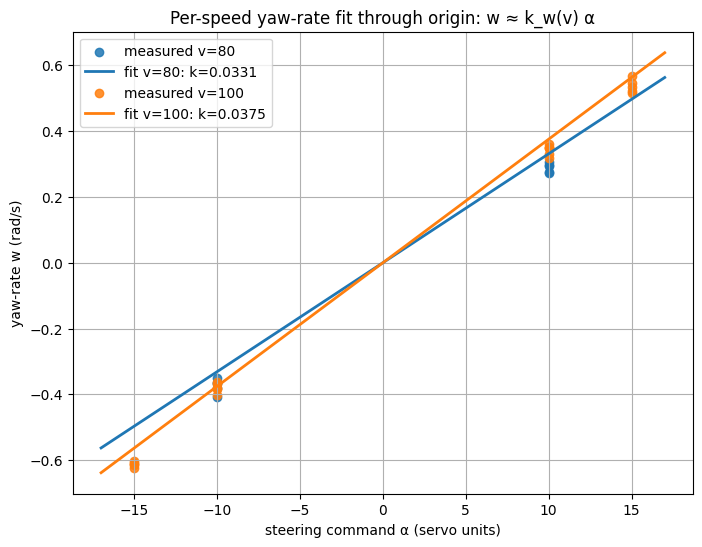

k_w(v) slopes (rad/s per steering unit):
  v=80: k_w = 0.033118
  v=100: k_w = 0.037549


In [6]:
def through_origin_slope(x, y):
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    denom = float(x @ x)
    return float((x @ y) / denom) if denom > 1e-12 else 0.0

speeds_unique = sorted(set(v.astype(int)))
k_w_by_speed = {}

alpha_grid = np.linspace(alpha.min()-2, alpha.max()+2, 200)

plt.figure(figsize=(8,6))
for v0 in speeds_unique:
    mask = (v == v0)
    a = alpha[mask]
    w0 = w[mask]
    k = through_origin_slope(a, w0)
    k_w_by_speed[v0] = k
    
    plt.scatter(a, w0, alpha=0.85, label=f"measured v={v0}")
    plt.plot(alpha_grid, k*alpha_grid, linewidth=2, label=f"fit v={v0}: k={k:.4f}")

plt.xlabel("steering command α (servo units)")
plt.ylabel("yaw-rate w (rad/s)")
plt.title("Per-speed yaw-rate fit through origin: w ≈ k_w(v) α")
plt.grid(True)
plt.legend()
plt.show()

print("k_w(v) slopes (rad/s per steering unit):")
for v0 in speeds_unique:
    print(f"  v={v0}: k_w = {k_w_by_speed[v0]:.6f}")

c_r = 3.526364371043104e-05 (rad/s) / (counts/s * steering_unit)


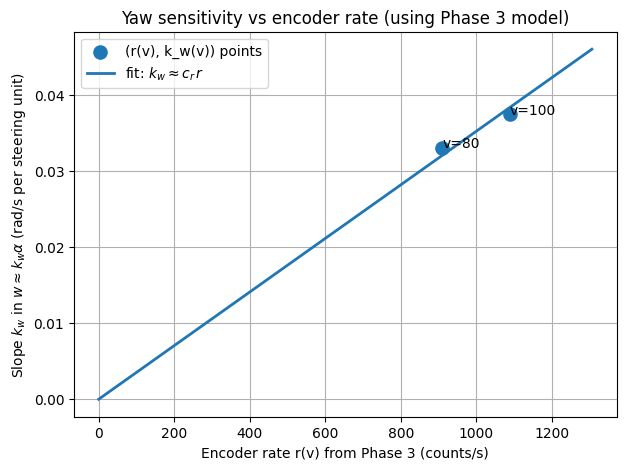

In [7]:
r_by_speed = {v0: counts_per_sec_from_speed(v0) for v0 in speeds_unique}

r_pts = np.array([r_by_speed[v0] for v0 in speeds_unique], dtype=float)
k_pts = np.array([k_w_by_speed[v0] for v0 in speeds_unique], dtype=float)

c_r = through_origin_slope(r_pts, k_pts)
print("c_r =", c_r, "(rad/s) / (counts/s * steering_unit)")

plt.figure(figsize=(7,5))
plt.scatter(r_pts, k_pts, s=90, label="(r(v), k_w(v)) points")

rgrid = np.linspace(0, max(r_pts)*1.2, 200)
plt.plot(rgrid, c_r*rgrid, linewidth=2, label=r"fit: $k_w \approx c_r\,r$")

for v0 in speeds_unique:
    plt.annotate(f"v={v0}", (r_by_speed[v0], k_w_by_speed[v0]))

plt.xlabel("Encoder rate r(v) from Phase 3 (counts/s)")
plt.ylabel(r"Slope $k_w$ in $w \approx k_w \alpha$ (rad/s per steering unit)")
plt.title("Yaw sensitivity vs encoder rate (using Phase 3 model)")
plt.grid(True)
plt.legend()
plt.show()

In [8]:
def w_from_speed_and_alpha(v_cmd, alpha_cmd):
    r = counts_per_sec_from_speed(v_cmd)   # counts/s
    return (c_r * r) * float(alpha_cmd)    # rad/s

# Compare measured vs model (quick check)
w_model = np.array([w_from_speed_and_alpha(v[i], alpha[i]) for i in range(len(w))], dtype=float)
resid = w - w_model
sigma_w2 = float(np.mean(resid**2))

print("sigma_w^2 (MSE) =", sigma_w2, "(rad/s)^2")

sigma_w^2 (MSE) = 0.0016015388112972787 (rad/s)^2


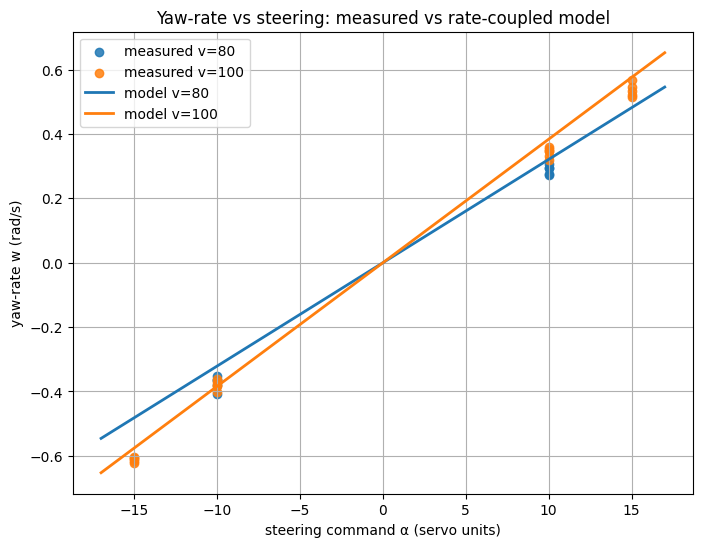

In [9]:
plt.figure(figsize=(8,6))

for v0 in speeds_unique:
    mask = (v == v0)
    plt.scatter(alpha[mask], w[mask], alpha=0.85, label=f"measured v={v0}")

alpha_grid = np.linspace(alpha.min()-2, alpha.max()+2, 200)
for v0 in speeds_unique:
    w_line = np.array([w_from_speed_and_alpha(v0, a) for a in alpha_grid])
    plt.plot(alpha_grid, w_line, linewidth=2, label=f"model v={v0}")

plt.xlabel("steering command α (servo units)")
plt.ylabel("yaw-rate w (rad/s)")
plt.title("Yaw-rate vs steering: measured vs rate-coupled model")
plt.grid(True)
plt.legend()
plt.show()

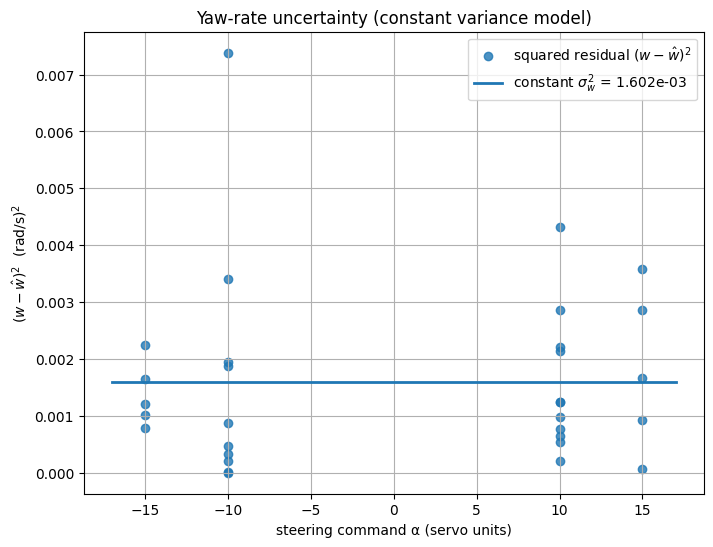

In [10]:
plt.figure(figsize=(8,6))
plt.scatter(alpha, resid**2, alpha=0.8, label=r"squared residual $(w-\hat{w})^2$")

agrid = np.linspace(alpha.min()-2, alpha.max()+2, 200)
plt.plot(agrid, np.full_like(agrid, sigma_w2), linewidth=2,
         label=rf"constant $\sigma_w^2$ = {sigma_w2:.3e}")

plt.xlabel("steering command α (servo units)")
plt.ylabel(r"$(w-\hat{w})^2$  (rad/s)$^2$")
plt.title("Yaw-rate uncertainty (constant variance model)")
plt.grid(True)
plt.legend()
plt.show()

In [11]:
print("---- paste into motion_models.py ----")
print(f"A1 = {A1:.18e}")
print(f"A2 = {A2:.18e}")
print(f"A3 = {A3:.18e}")
print(f"C_R = {c_r:.18e}        # (rad/s) / (counts/s * steering_unit)")
print(f"SIGMA_W2 = {sigma_w2:.18e}  # (rad/s)^2")

print("\ndef counts_per_sec_from_speed(v_cmd):")
print("    v = float(v_cmd)")
print("    r = A1*v + A2*(v**2) + A3*(v**3)")
print("    return max(0.0, r)")

print("\ndef rotational_velocity_w(v_cmd, alpha_cmd):")
print("    r = counts_per_sec_from_speed(v_cmd)")
print("    return (C_R * r) * float(alpha_cmd)")

---- paste into motion_models.py ----
A1 = -2.389748299319578351e+01
A2 = 8.136904761904759642e-01
A3 = -4.658503401360606679e-03
C_R = 3.526364371043103914e-05        # (rad/s) / (counts/s * steering_unit)
SIGMA_W2 = 1.601538811297278713e-03  # (rad/s)^2

def counts_per_sec_from_speed(v_cmd):
    v = float(v_cmd)
    r = A1*v + A2*(v**2) + A3*(v**3)
    return max(0.0, r)

def rotational_velocity_w(v_cmd, alpha_cmd):
    r = counts_per_sec_from_speed(v_cmd)
    return (C_R * r) * float(alpha_cmd)
